In [1]:
# This Source Code Form is subject to the terms of the Mozilla Public
# License, v. 2.0. If a copy of the MPL was not distributed with this
# file, You can obtain one at https://mozilla.org/MPL/2.0/.

# Mapas Urbano Gran Santiago

**Autor**: Diego Caro ([@diegocaro](https://twitter.com/diegocaro)).

El objetivo de este notebook es contarles como procesar la información geográfica del Censo 2017. En particular, trabajaremos en extraer las áreas urbanas de las comunas del Gran Santiago. Puedes encontrar otras regiones en el sitio web del [Censo 2017](http://www.censo2017.cl/servicio-de-mapas/).

**Descargo de responsabilidad**: este notebook no constituye información cartográfica oficial de la República de Chile. Su único fin es educativo, y no debe ser utilizada como referencia para decisiones oficiales sobre la pandemia.

**Reconocimiento**: este notebook está inspirado por el gran trabajo de mi amigo [@carnby](https://github.com/carnby/mapas_censo_2017).

## Preámbulo: descargando datos y módulos de Python

La cartografía de la Región Metropolitana está disponible en el archivo [r13.rar](https://www.ine.cl/docs/default-source/descarga-cartograf%C3%ADa-censo-2017/r13.rar). Debes descomprimir el archivo dentro del directorio `./input/`.

Chequea que efectivamente estén los shapefiles del censo en el directorio input. Deberías ver algo así:

In [2]:
from glob import glob
glob('./input/R13/*')

['./input/R13/DISTRITO_C17.prj',
 './input/R13/COMUNA_C17.shp',
 './input/R13/COMUNA_C17.shp.xml',
 './input/R13/COMUNA_C17.cpg',
 './input/R13/COMUNA_C17.shx',
 './input/R13/COMUNA_C17.dbf',
 './input/R13/DISTRITO_C17.shp.xml',
 './input/R13/DISTRITO_C17.shx',
 './input/R13/DISTRITO_C17.cpg',
 './input/R13/DISTRITO_C17.shp',
 './input/R13/COMUNA_C17.prj',
 './input/R13/DISTRITO_C17.dbf']

In [3]:
# si esta celda hace error, es que no haz descargado o descomprimido los shapefiles!
assert(len(glob('./input/R13/*'))==12)

En esta celda configuramos el notebook para que muestre las figuras en alta resolución (y cargamos los mejores módulos de Python  ❤️).

In [4]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(palette='viridis', context='notebook', font_scale=1.0, font='Avenir Next Condensed')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Cargando los datos geográficos

In [5]:
comunas = gpd.read_file('input/R13/COMUNA_C17.shp')
comunas.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,1.625330,0.066035,"POLYGON ((-70.61889 -33.73808, -70.61811 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,"POLYGON ((-70.63192 -33.64634, -70.63207 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78914 -33.36153, -70.78824 -33.3..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,CERRO NAVIA,0.170180,0.001076,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13301,COLINA,1.692007,0.093820,"POLYGON ((-70.59630 -32.95138, -70.59673 -32.9..."


GeoPandas permite colorear un shapefile según los valores de una columna. Por ejemplo, podemos colorear según la Provincia a la que pertenece cada comuna.

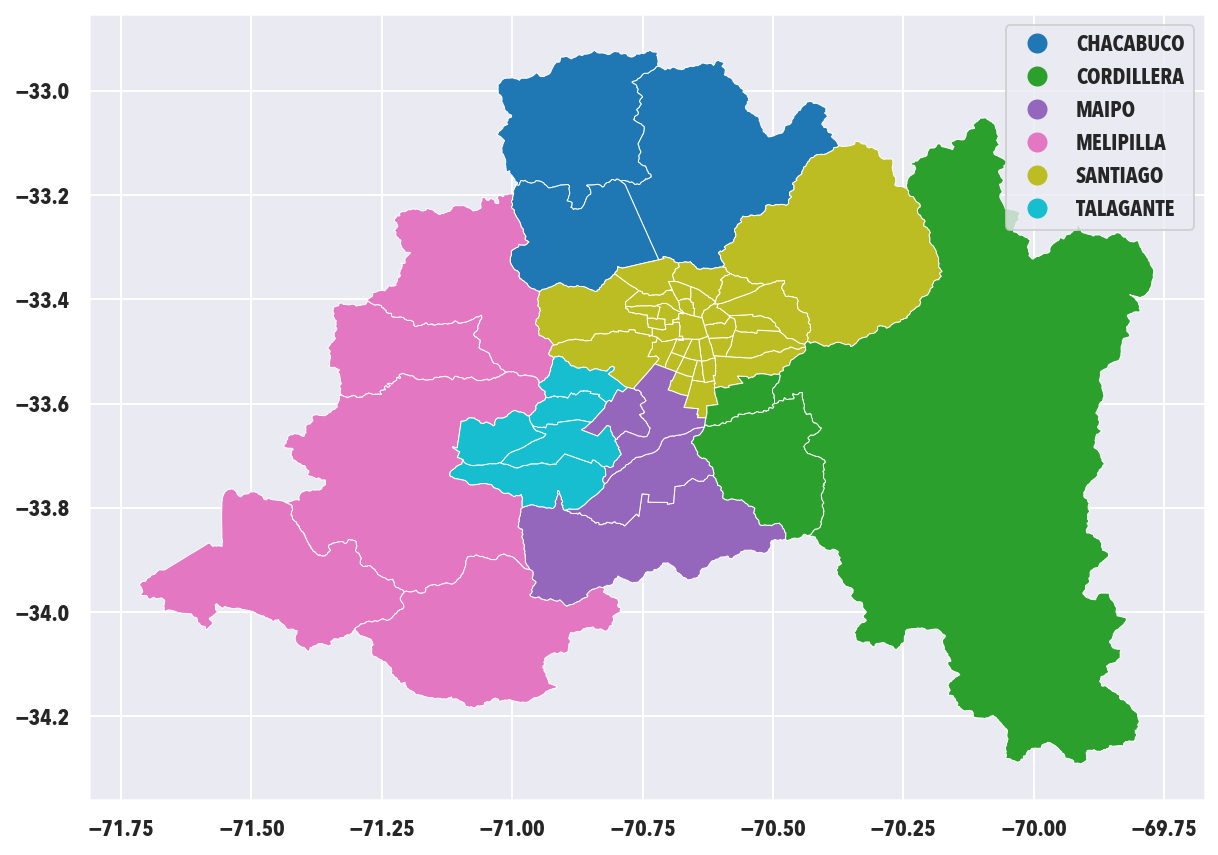

In [6]:
comunas.plot(figsize=(10,10), linewidth=0.5, column='NOM_PROVIN', legend=True)

Ahora cargaremos los distritos, que se el documento [Alcances y Consideraciones para el usuario del Censo](http://www.censo2017.cl/servicio-de-mapas/descargas/mapas/alcances-base-cartografica-censo2017.pdf) (p.3)
> \[...\] Para  efectos legales, es  la Comuna  la  unidad  básica de  administración  del  territorio.  
> \[...\] El territorio comunalse divideen distritos, los que pueden ser urbanos, rurales o mixtos.

In [7]:
distritos = gpd.read_file('input/R13/DISTRITO_C17.shp')
distritos.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,COD_DISTRI,TIPO_DISTR,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,7,RURAL,0.306170,0.004895,"POLYGON ((-70.61889 -33.73808, -70.61811 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,6,MIXTO,0.283347,0.003383,"POLYGON ((-70.69162 -33.80459, -70.69164 -33.8..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,9,MIXTO,0.637308,0.013032,"POLYGON ((-70.86894 -33.81140, -70.86883 -33.8..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,5,RURAL,0.539426,0.010221,"POLYGON ((-70.57773 -33.82456, -70.57751 -33.8..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,8,MIXTO,0.443465,0.006985,"POLYGON ((-70.80237 -33.82702, -70.80234 -33.8..."


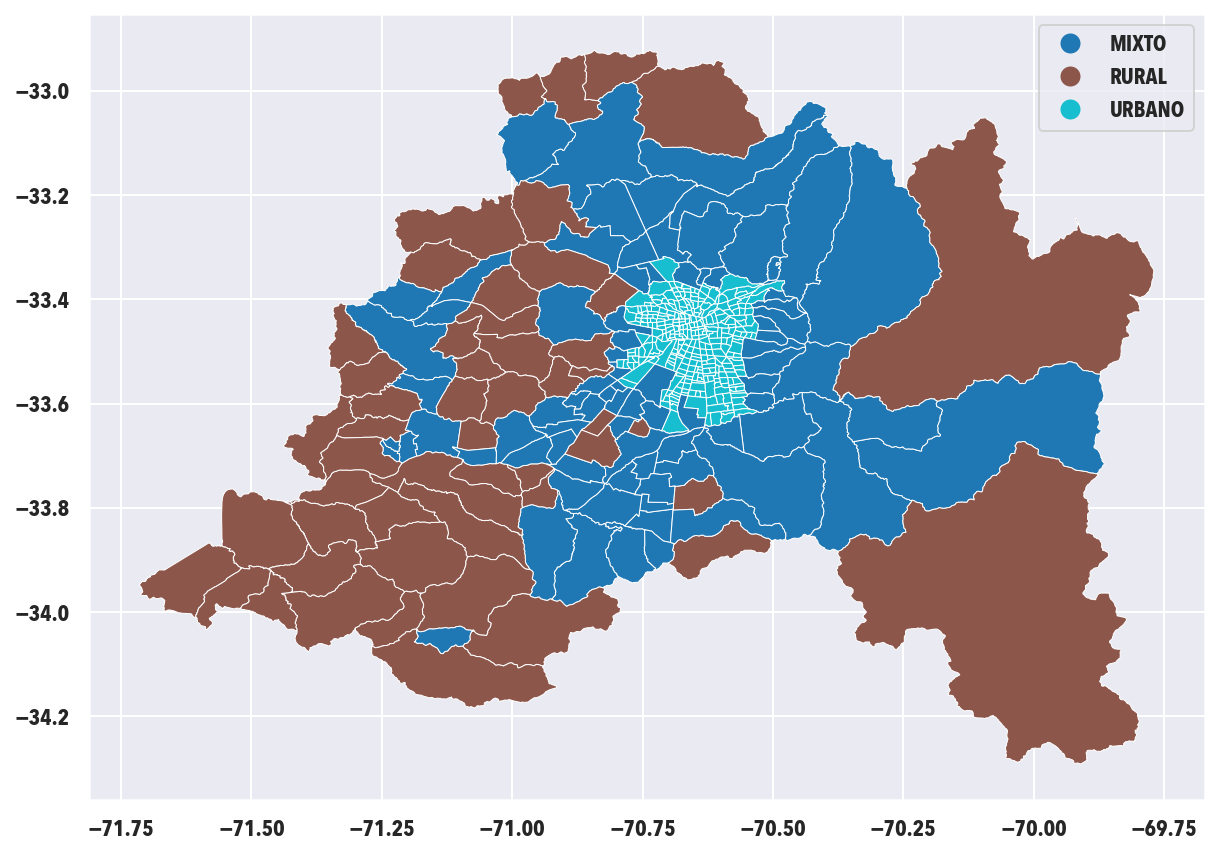

In [8]:
distritos.plot(figsize=(10,10), linewidth=0.5, column='TIPO_DISTR', legend=True)

## Filtrando datos

Ahora nos concentraremos en el área **urbana** del Gran Santiago. Recuerda que los distritos pueden ser de tipo Urbano, Rural o Mixto. Nos quedaremos con los Urbanos.

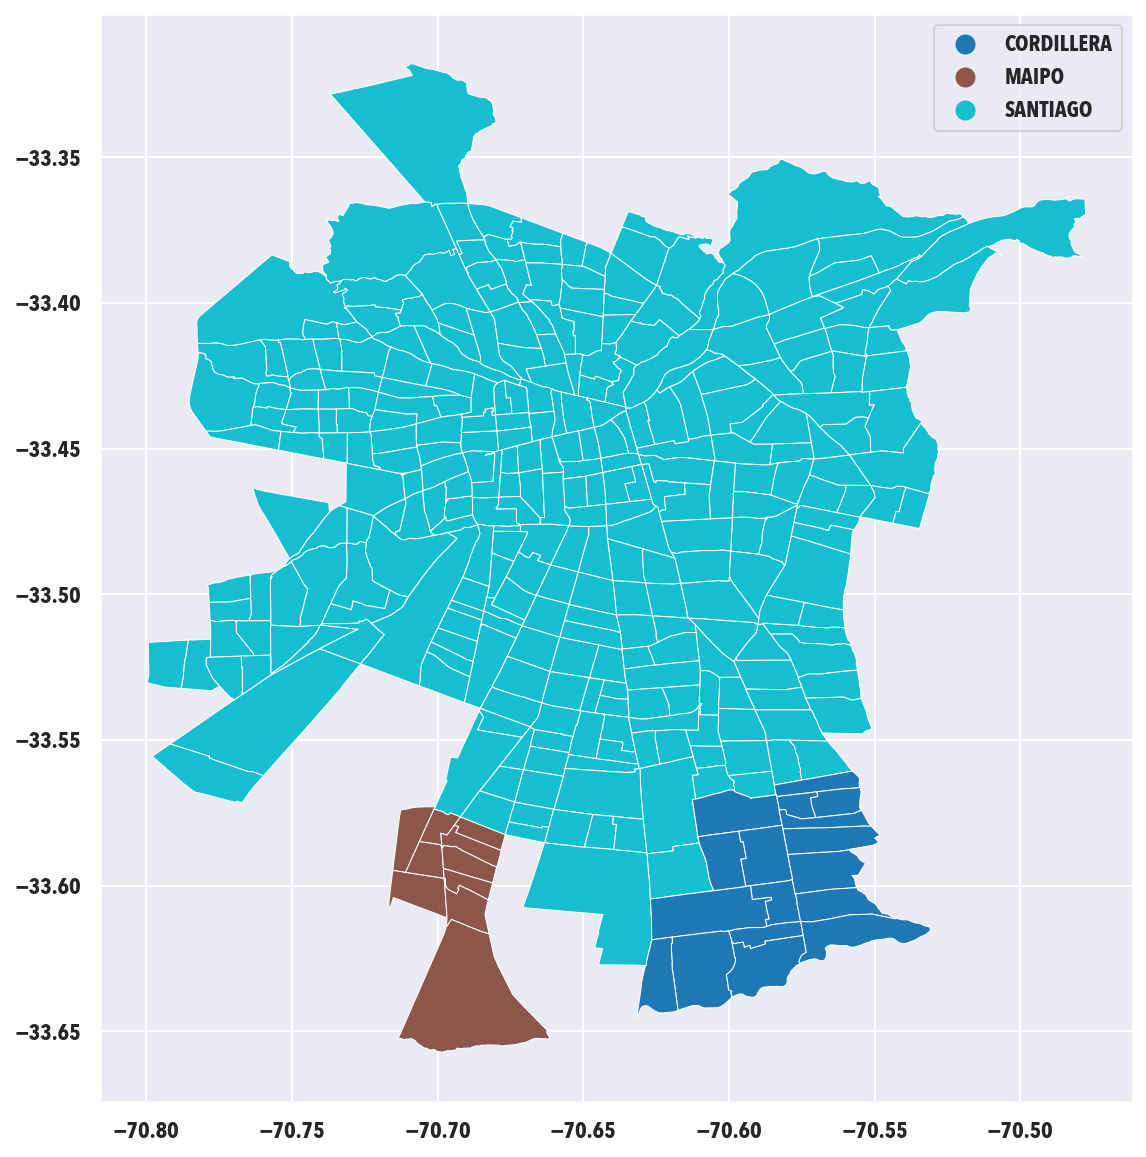

In [9]:
# distritos del Gran Santiago
urban_distritos = distritos[distritos.TIPO_DISTR == 'URBANO']
ax = urban_distritos.plot(figsize=(10,10),linewidth=0.5,column='NOM_PROVIN', legend=True)

Perfecto! Pero... ¿cómo podemos calcular el área urbana de una comuna?. Exacto, uniendo los distritos urbanos :D

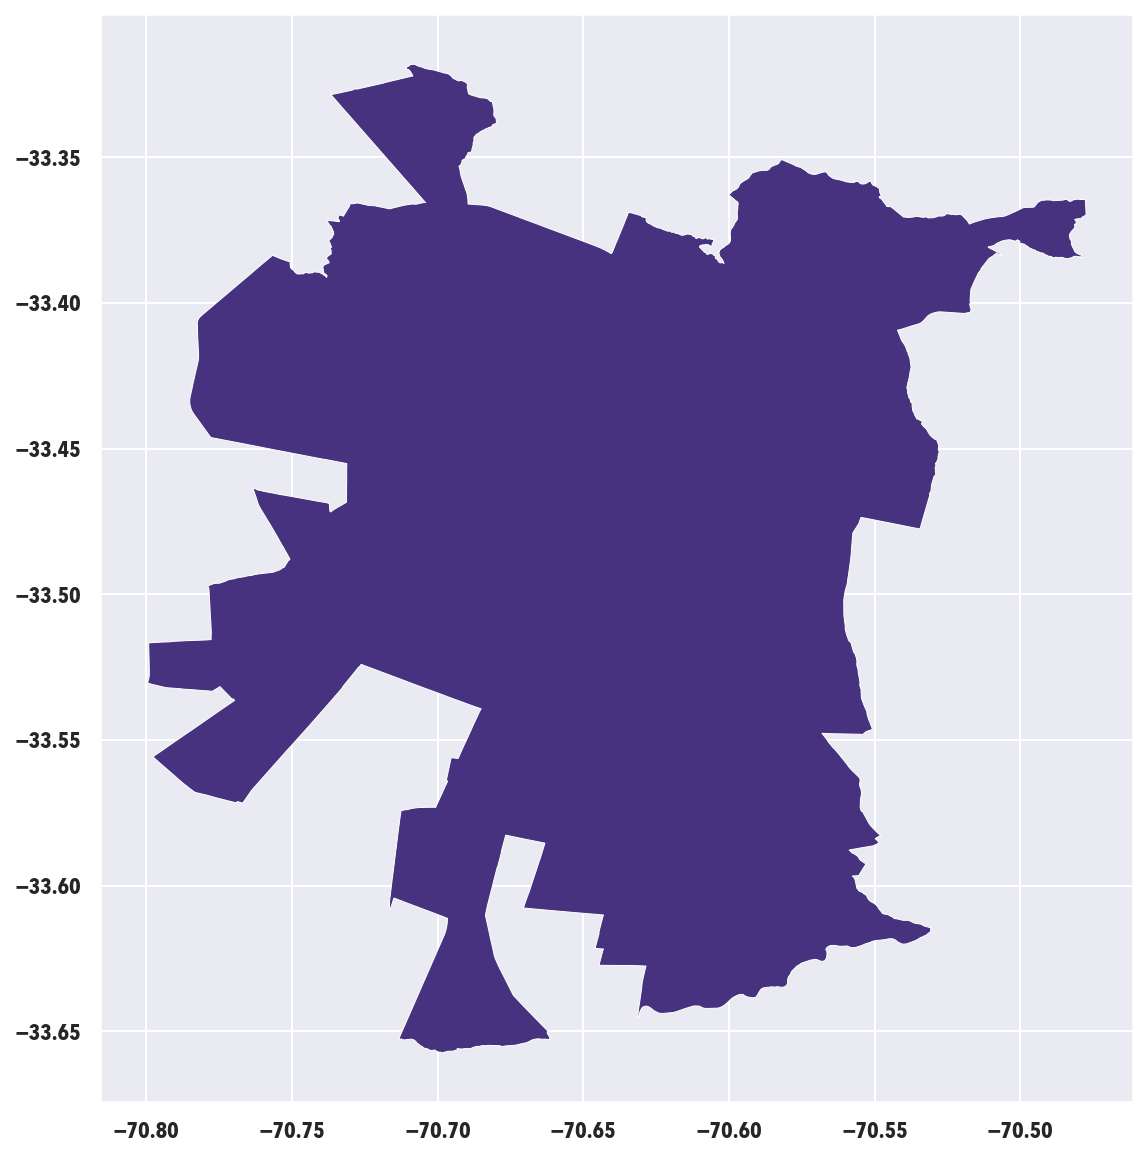

In [10]:
# union de todas las áreas urbanas del Gran Santiago
EPSILON=0.00000001 # pequeño truquillo para simplificar la geometría

urban_stgo = urban_distritos.dissolve(by='REGION').geometry.buffer(-EPSILON)
assert urban_stgo.shape[0] == 1
urban_stgo.plot(figsize=(10,10),linewidth=0.5,)

Y ahora calculamos la intersección del área urbana de la RM, con las comunas del Gran Santiago.

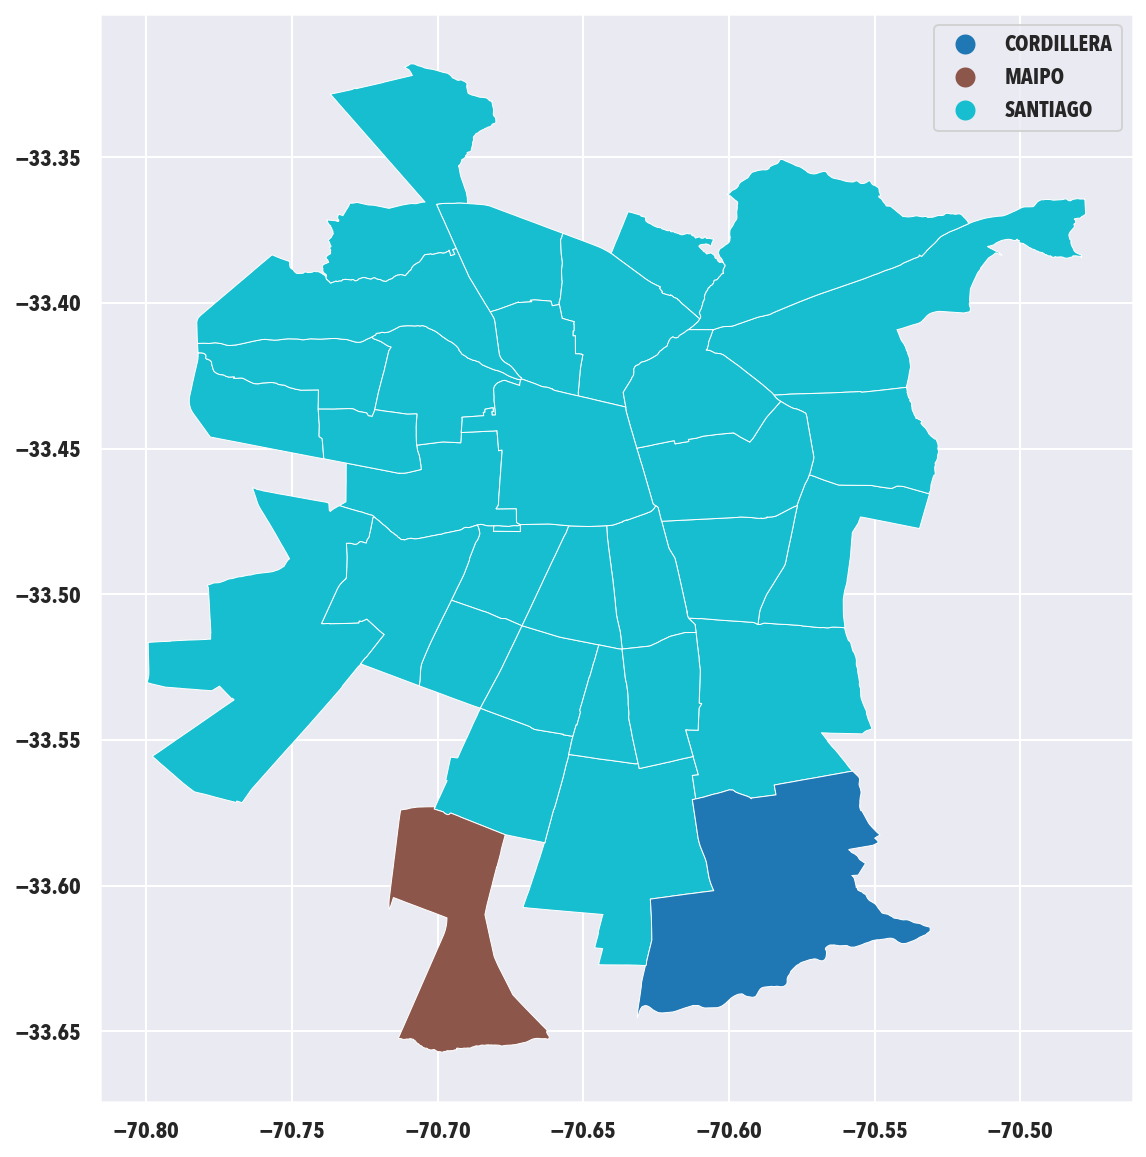

In [11]:
urban_comunas = comunas.assign(geometry = lambda x: x.geometry.map(lambda dc: dc.intersection(urban_stgo.iloc[0])))
urban_comunas = urban_comunas[~urban_comunas.is_empty]
urban_comunas.plot(figsize=(10,10),linewidth=0.5,column='NOM_PROVIN', legend=True)

## Final: visualizando y guardando datos

Ya tenemos el área urbana del Gran Santiago, ahora aprovecharemos de indicar el nombre de cada comuna en la visualización del mapa.

In [12]:
# este es un truquillo para agregar borde al texto
# más detalles en https://matplotlib.org/3.2.1/tutorials/advanced/patheffects_guide.html
import matplotlib.patheffects as path_effects

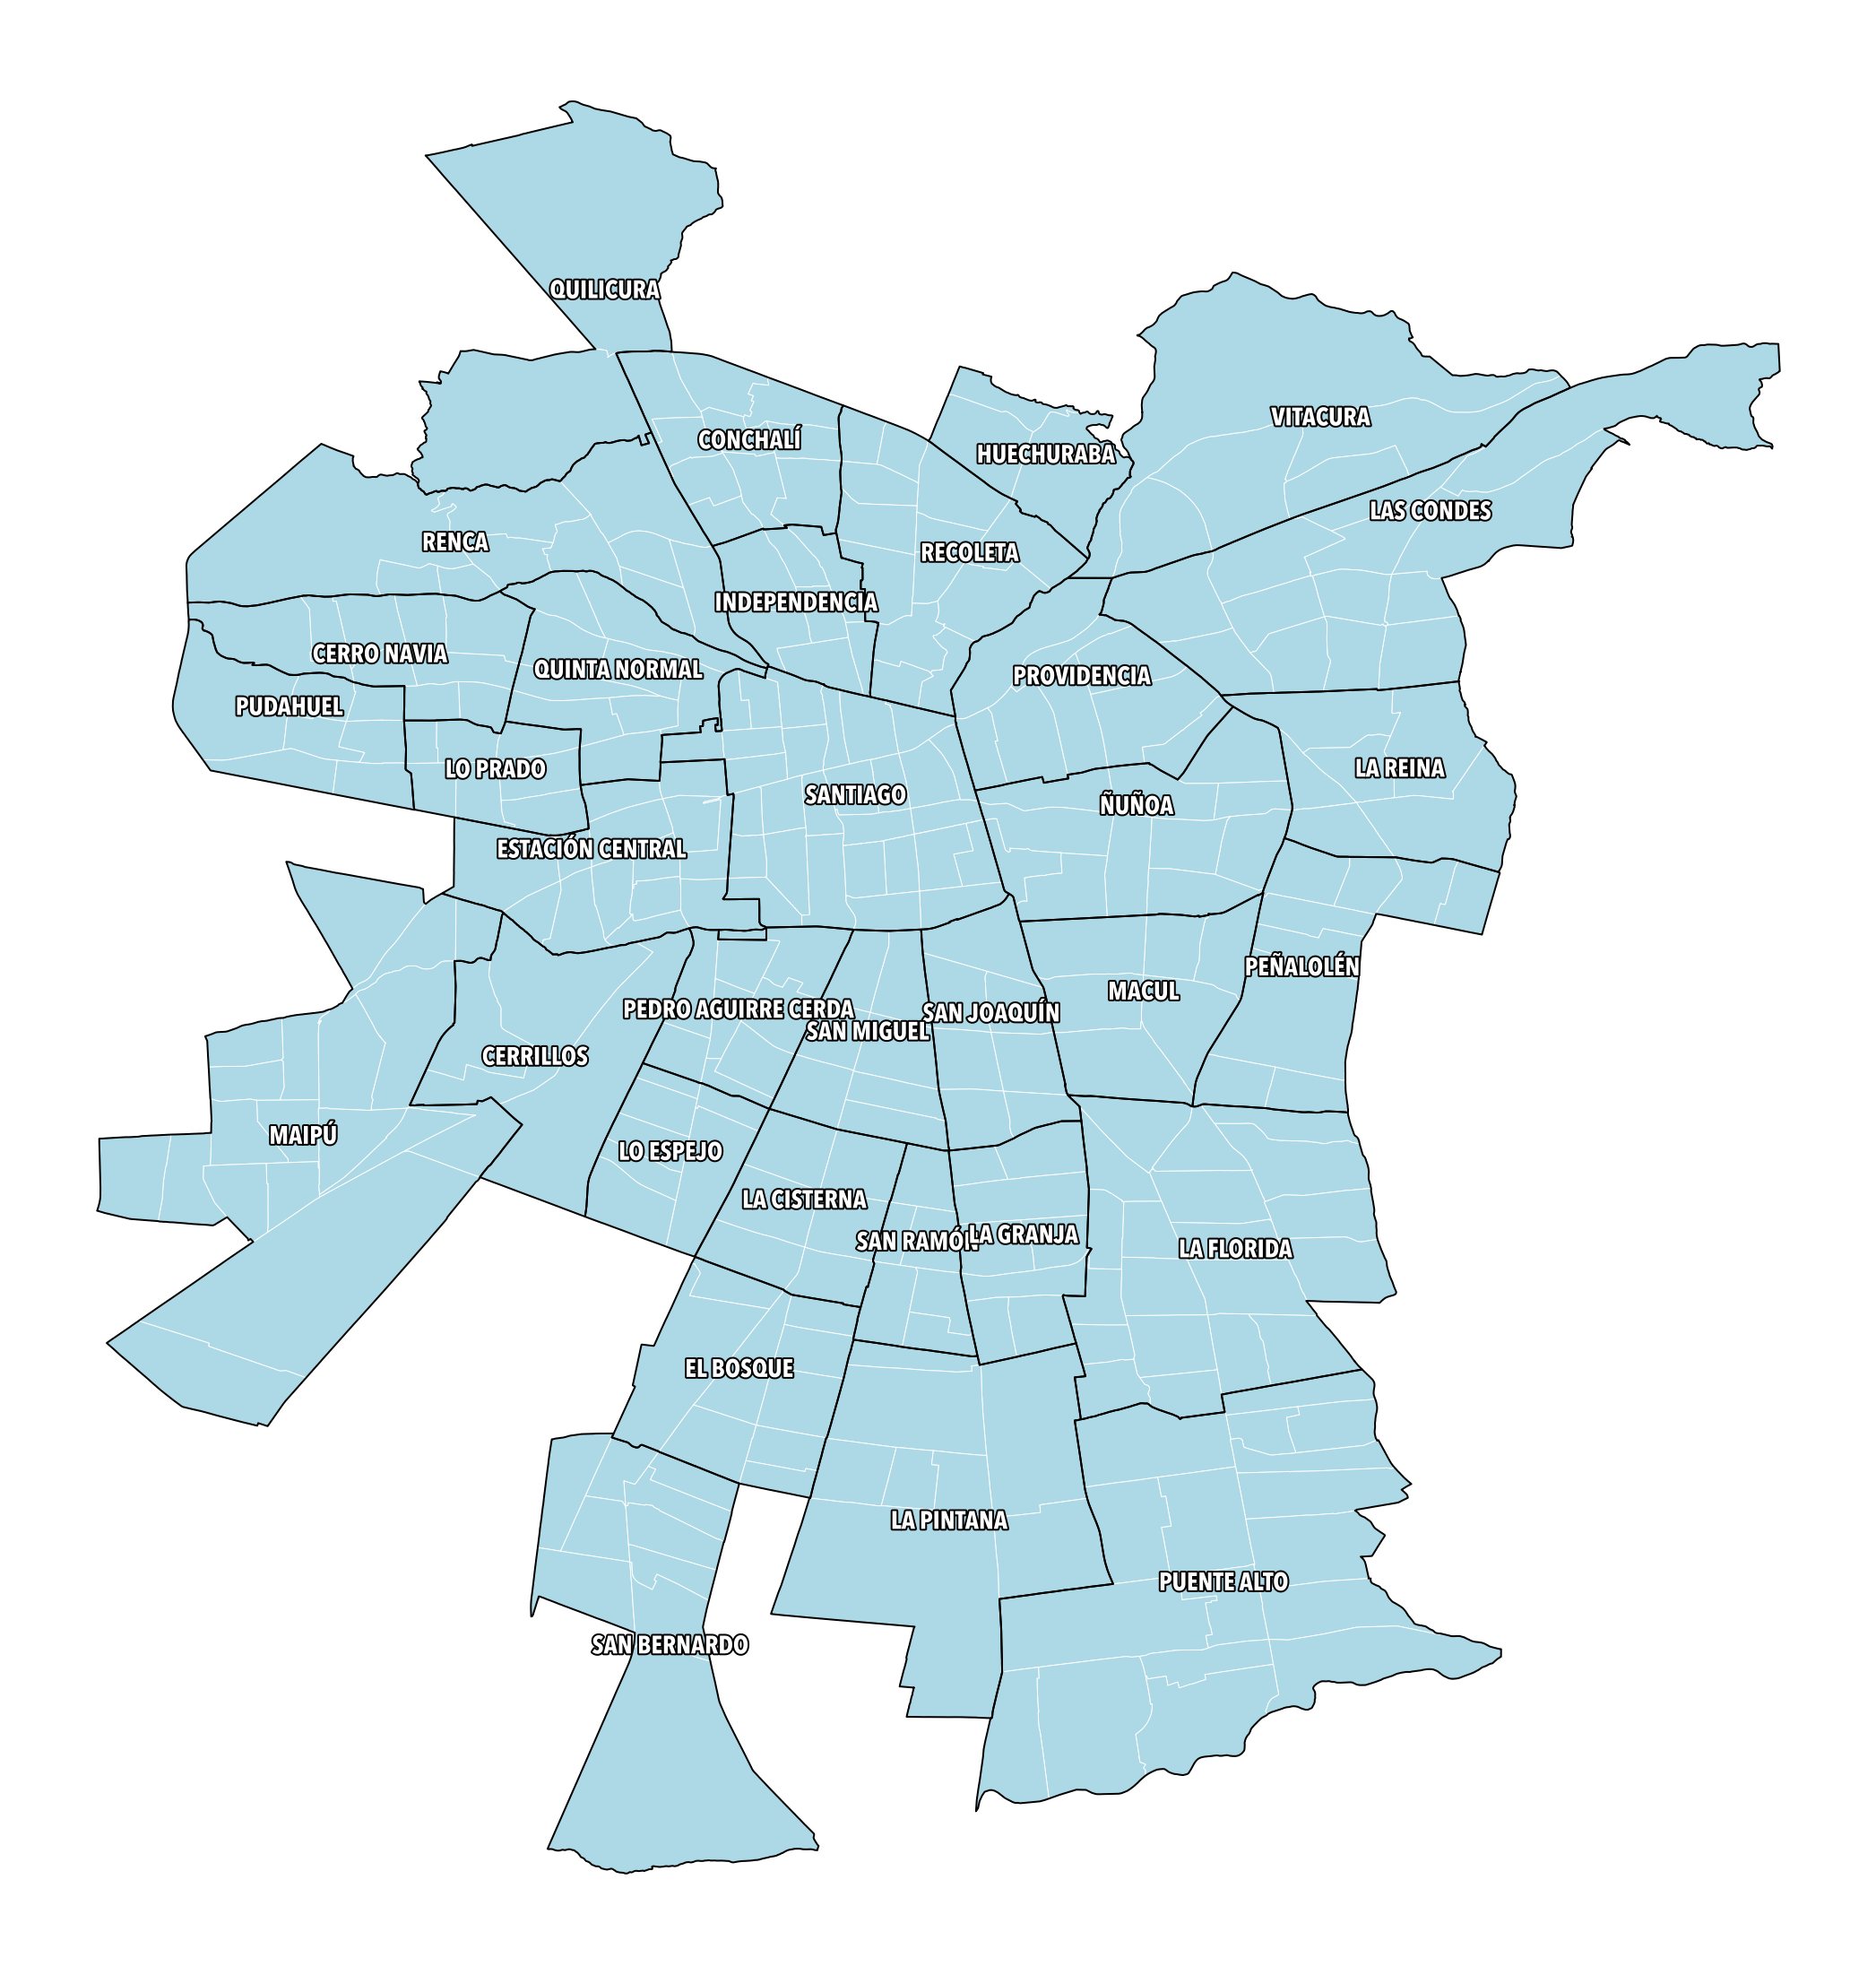

In [13]:
ax = urban_distritos.plot(figsize=(20,20), linewidth=0.5, edgecolor='white', facecolor='lightblue')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)

for row in urban_comunas.itertuples():
    comuna = row.NOM_COMUNA
    centroid = row.geometry.representative_point()
    t = ax.text(centroid.x, centroid.y, comuna 
                ,horizontalalignment='center', fontsize=14, fontweight='bold', color='white'
                ,fontstretch='condensed')
    t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])

ax.axis('off')
plt.savefig('images/urban_stgo.png', dpi=150, bbox_inches='tight');

Ahora guardamos los datos en formato ESRI y GeoJson. ¡Espero que les sirva!

In [14]:
urban_stgo.to_file('./output/urban_stgo.shp', driver='ESRI Shapefile')
urban_distritos.to_file('./output/urban_distritos.shp', driver='ESRI Shapefile')
urban_comunas.to_file('./output/urban_comunas.shp', driver='ESRI Shapefile')

urban_stgo.to_file('./output/urban_stgo.json', driver='GeoJSON')
urban_distritos.to_file('./output/urban_distritos.json', driver='GeoJSON')
urban_comunas.to_file('./output/urban_comunas.json', driver='GeoJSON')

# Referencias:
- Departamento de Geografía, Instituto Nacional de Estadísticas. 2018. [Alcances y Consideraciones para el usuario del Censo 2017 Chile](http://www.censo2017.cl/servicio-de-mapas/descargas/mapas/alcances-base-cartografica-censo2017.pdf).  Santiago, Chile. Recuperado desde http://www.censo2017.cl/servicio-de-mapas/descargas/mapas/alcances-base-cartografica-censo2017.pdf.
- Instituto Nacional de Estadísticas. 2018. [Cartografía Censo 2018](http://www.censo2017.cl/servicio-de-mapas/). Santiago, Chile. Recuperado desde http://www.censo2017.cl/servicio-de-mapas/.